# Market Mix Modelling Tango

In [9]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Load data:
with pd.ExcelFile("../data/raw/Data AA Graph.xlsx") as xlsx:
    omset_df = pd.read_excel(xlsx, "Omset")
    aa_graph_df = pd.read_excel(xlsx, "Data")

# Data Preprocessing

In [10]:
from itertools import product

# Constant 
START_DATE = '2015-01-01'
END_DATE = '2024-03-01'

# Preprocess Omset
def preprocess_omset(df):
    # 1. Create `Periode` column (%Y-%m-%d)
    df['Periode'] = pd.to_datetime(df['Thn'].astype(str) + '-' + df['Bln'].astype(str) + '-01')
    df = df.drop(columns=['Thn', 'Bln'])
    df['KP'] = df['KP'].str.upper()

    # 2. Groupby sum aggregation by `Periode` and `KP`
    df = df.groupby(by=['Periode', 'KP']).agg({'QtyKrt': 'sum', 'Rp': 'sum', 'EC': 'sum'}).reset_index()

    # 3. Filter to only use data until 01-04-2024
    df = df[df['Periode']<=END_DATE]

    # 4. Add zeros for missing values between '2015-01-01' and '2024-03-01'
    kp = df['KP'].unique()
    date_ranges = pd.date_range(start=START_DATE, end=END_DATE, freq='MS')

    complete_date_df = pd.DataFrame(product(date_ranges, kp), columns=['Periode', 'KP'])
    df = complete_date_df.merge(df, how='left', on=['Periode', 'KP']).fillna(0)
    df = df.rename(columns={'QtyKrt': 'Sales'})

    return df

preprocessed_omset_df = preprocess_omset(omset_df.copy())

def preprocess_aa_graph(df):
    # 1. Drop column from `Wilayah`
    df = df.drop(columns=['Wilayah'])

    # 2. Rename column from `Product` to `KP`
    df = df.rename(columns={"Product": "KP"})

    # 3. Normalize string values
    for col in df.select_dtypes('object'):
        df[col] = df[col].str.upper()

    # 4. Change unit of scale from 'Puluhan Jt Rp' TO 'Jt Rupiah'
    def change_unit_scale(row):
        if re.match('.*(PULUHAN JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 10_000_000
            row['Dimensi'] = re.sub('PULUHAN JT RP', 'RP', row['Dimensi'])
        elif re.match('.*(JT RP).*', row['Dimensi']):
            row['Value'] = row['Value'] * 1_000_000
            row['Dimensi'] = re.sub('JT RP', 'RP', row['Dimensi'])
        return row
    df = df.apply(change_unit_scale, axis=1)

    # 5. Change inconsistensies of string in `Dimensi`
    df['Dimensi'] = df['Dimensi'].replace(to_replace=r'YG', value='YANG', regex=True)
    
    # 6. Filter to only use data until 01-03-2024
    df = df[df['Periode']<=END_DATE]
    return df

preprocessed_aa_graph_df = preprocess_aa_graph(aa_graph_df.copy())

In [11]:
def get_data_by_kp(kp, omset_columns, aa_graph_columns):
    subset_omset_df = preprocessed_omset_df[preprocessed_omset_df['KP']==kp]
    subset_omset_df = subset_omset_df[omset_columns]
    subset_aa_graph_df= preprocessed_aa_graph_df[aa_graph_columns]
    df_with_exog = subset_omset_df.merge(subset_aa_graph_df, on=['KP', 'Periode'])
    df_with_exog = df_with_exog.pivot(index=['KP', 'Periode', 'Sales'], columns='Dimensi', values='Value').fillna(0).reset_index()
    df_with_exog = df_with_exog.rename_axis(None, axis=1)
    return df_with_exog

# Market Mix Modelling Tango

In [12]:
kp = 'TANGO WAFER'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)']

# Data for statsforecast modelling
tango_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_df = tango_df[['Periode', 'KP', 'Sales']+exog_columns]

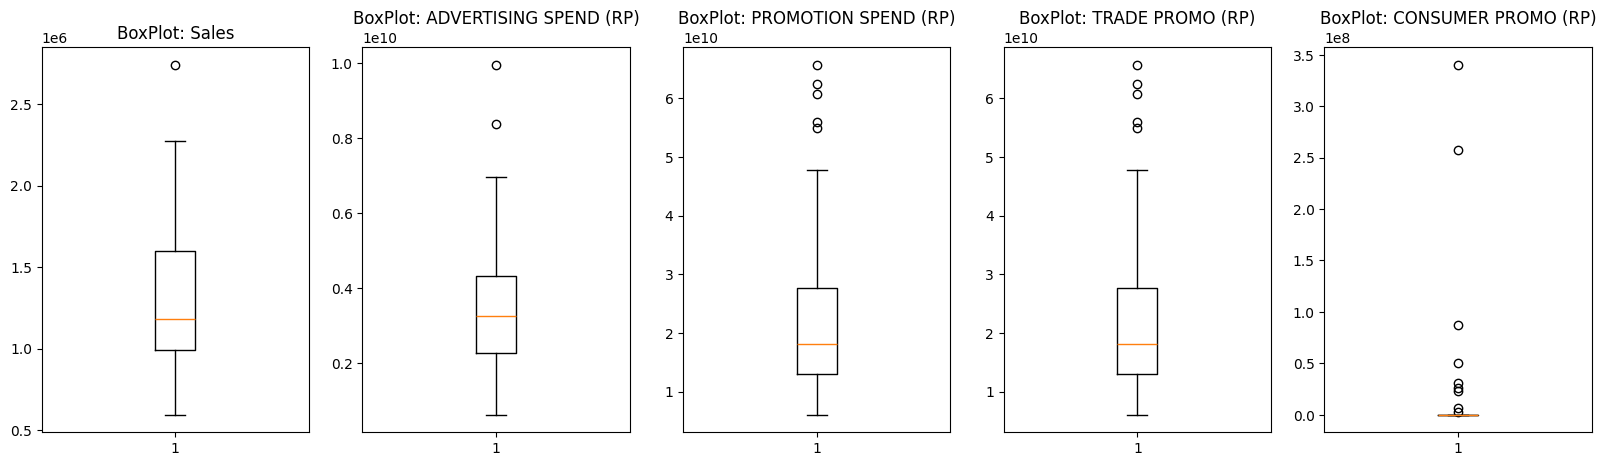

In [13]:
# Identify outliers
fig, ax = plt.subplots(ncols=len(['Sales']+exog_columns), figsize=(20, 5))
for idx, col in enumerate(['Sales']+exog_columns):
    ax[idx].boxplot(tango_df[col])
    ax[idx].set_title("BoxPlot: {}".format(col))
plt.show()

# Exploratory Data Analysis

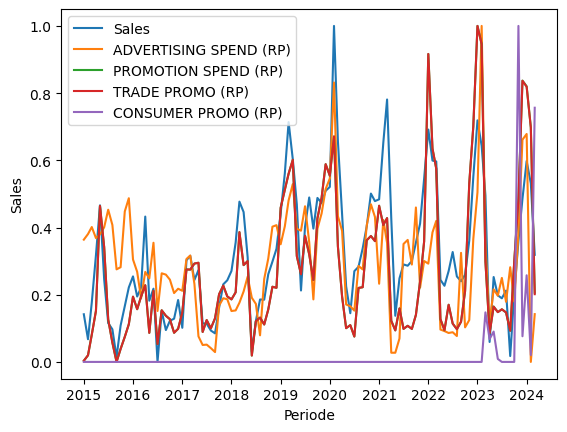

In [16]:
from sklearn.preprocessing import MinMaxScaler
tango_df_scaled = tango_df.copy()
scaler = MinMaxScaler()
tango_df_scaled[['Sales']+exog_columns] = scaler.fit_transform(tango_df_scaled[['Sales']+exog_columns]) 
sns.lineplot(data=tango_df_scaled, x='Periode', y='Sales', label='Sales')
sns.lineplot(data=tango_df_scaled, x='Periode', y='ADVERTISING SPEND (RP)', label='ADVERTISING SPEND (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='PROMOTION SPEND (RP)', label='PROMOTION SPEND (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='TRADE PROMO (RP)', label='TRADE PROMO (RP)')
sns.lineplot(data=tango_df_scaled, x='Periode', y='CONSUMER PROMO (RP)', label='CONSUMER PROMO (RP)')
plt.legend()

## Plot Linear Regression Line

C:\Users\923006079\AppData\Local\Temp\ipykernel_10608\739362948.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_10608\739362948.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_10608\739362948.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


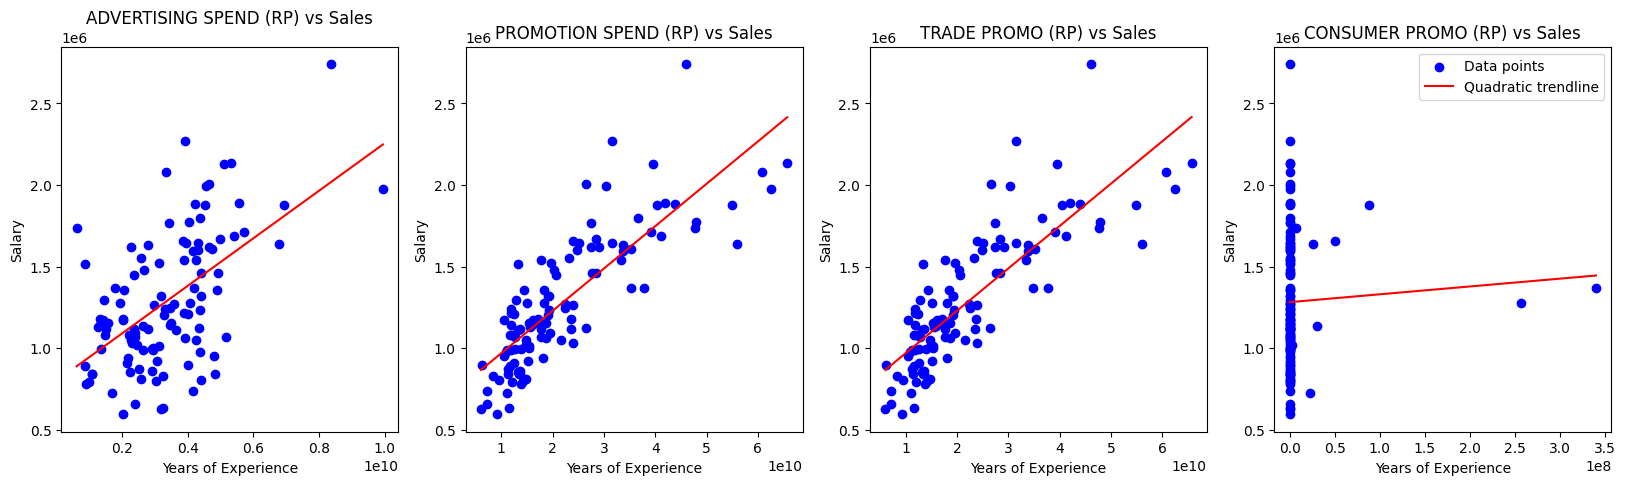

In [24]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(ncols=len(exog_columns), figsize=(20, 5))

for idx, col in enumerate(exog_columns):
    # Step 1: Generate some sample data
    x = tango_df[col].to_numpy()
    y = tango_df['Sales'].to_numpy()

    # Step 1: Normalize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_normalized = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Step 2: Fit a quadratic polynomial to the normalized data
    coefficients = np.polyfit(x_normalized, y_normalized, 1)
    quadratic_trendline = np.poly1d(coefficients)

    # Step 3: Generate y values for the trendline
    x_sorted = np.sort(x_normalized)
    y_trend = quadratic_trendline(x_sorted)

    # Step 4: Inverse transform the trendline values to original scale
    x_sorted_original = scaler_x.inverse_transform(x_sorted.reshape(-1, 1)).flatten()
    y_trend_original = scaler_y.inverse_transform(y_trend.reshape(-1, 1)).flatten()

    # Step 5: Plot the scatter plot and the quadratic trendline
    ax[idx].scatter(x, y, label='Data points', color='blue')
    ax[idx].plot(x_sorted_original, y_trend_original, color='red', label='Quadratic trendline')
    ax[idx].set_xlabel('Years of Experience')
    ax[idx].set_ylabel('Salary')
    ax[idx].set_title("{} vs Sales".format(col))
    plt.legend()
plt.show()

## Plot Polynomial Linear Regression Line

C:\Users\923006079\AppData\Local\Temp\ipykernel_10608\2320701666.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_10608\2320701666.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\923006079\AppData\Local\Temp\ipykernel_10608\2320701666.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


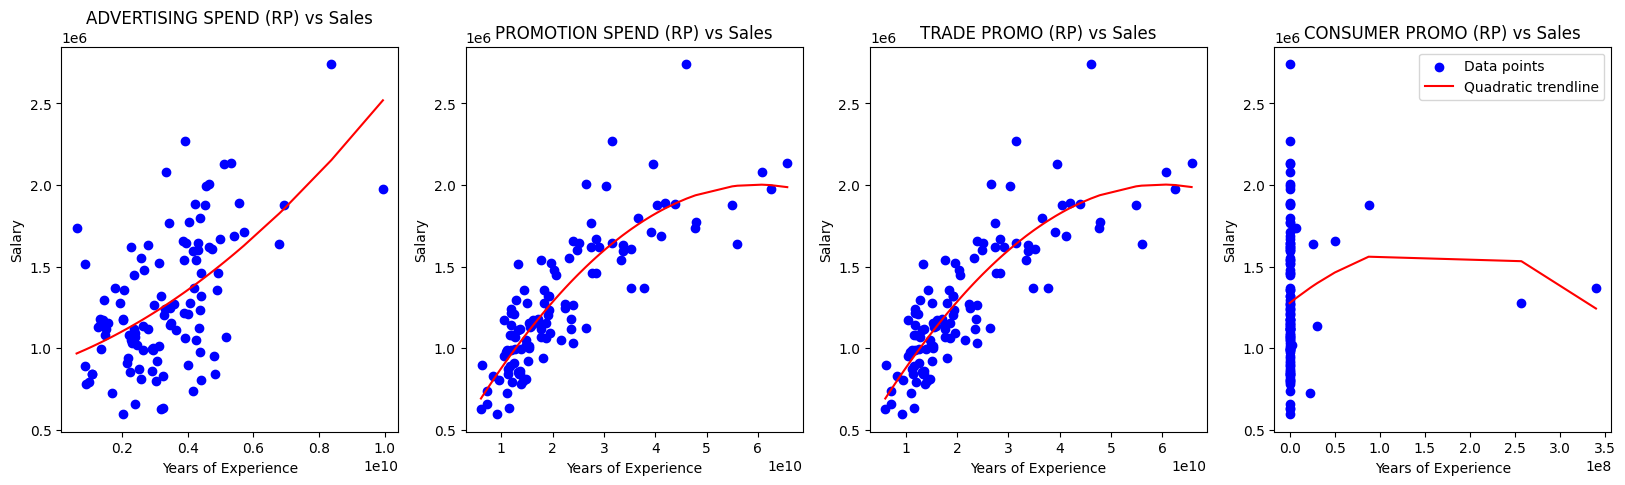

In [25]:
from sklearn.preprocessing import StandardScaler
fig, ax = plt.subplots(ncols=len(exog_columns), figsize=(20, 5))

for idx, col in enumerate(exog_columns):
    # Step 1: Generate some sample data
    x = tango_df[col].to_numpy()
    y = tango_df['Sales'].to_numpy()

    # Step 1: Normalize the data
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_normalized = scaler_x.fit_transform(x.reshape(-1, 1)).flatten()
    y_normalized = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

    # Step 2: Fit a quadratic polynomial to the normalized data
    coefficients = np.polyfit(x_normalized, y_normalized, 2)
    quadratic_trendline = np.poly1d(coefficients)

    # Step 3: Generate y values for the trendline
    x_sorted = np.sort(x_normalized)
    y_trend = quadratic_trendline(x_sorted)

    # Step 4: Inverse transform the trendline values to original scale
    x_sorted_original = scaler_x.inverse_transform(x_sorted.reshape(-1, 1)).flatten()
    y_trend_original = scaler_y.inverse_transform(y_trend.reshape(-1, 1)).flatten()

    # Step 5: Plot the scatter plot and the quadratic trendline
    ax[idx].scatter(x, y, label='Data points', color='blue')
    ax[idx].plot(x_sorted_original, y_trend_original, color='red', label='Quadratic trendline')
    ax[idx].set_xlabel('Years of Experience')
    ax[idx].set_ylabel('Salary')
    ax[idx].set_title("{} vs Sales".format(col))
    plt.legend()
plt.show()

## Pearson Correlation

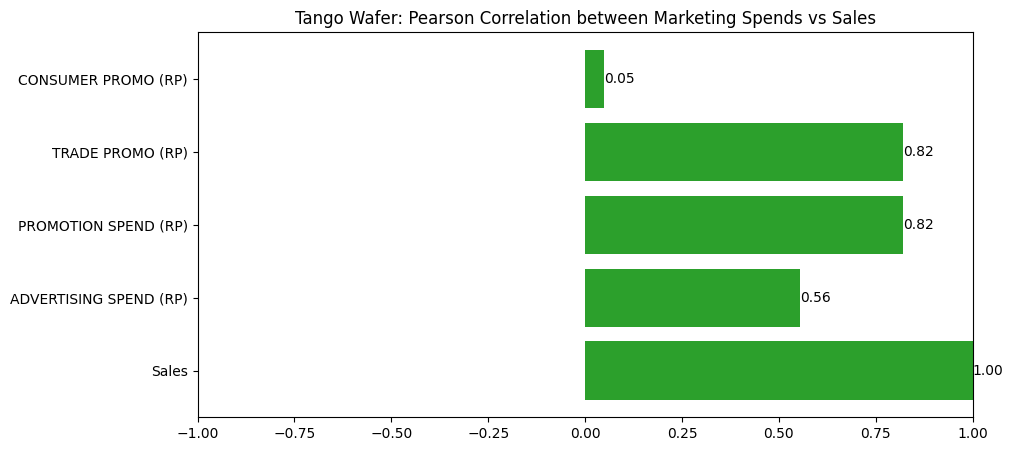

In [26]:
def plot_correlation_coefficient(data, title):
    plt.figure(figsize=(10, 5))
    colors = ['tab:green' if value >= 0 else 'tab:red' for value in data.values]
        # Create the horizontal bar plot
    bars = plt.barh(data.index, data.values, color=colors)
    
    # Add annotations
    for bar in bars:
        width = bar.get_width()
        if width > 0:
            plt.text(width+0.04, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                 ha='center', va='center', color='black', fontsize=10)
        else: 
            plt.text(width-0.04, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', 
                 ha='center', va='center', color='black', fontsize=10)
    plt.title(title)
    plt.xlim([-1, 1])
    plt.show()

plot_correlation_coefficient(tango_df[['Sales']+exog_columns].corr()['Sales'], "Tango Wafer: Pearson Correlation between Marketing Spends vs Sales")
plt.show()

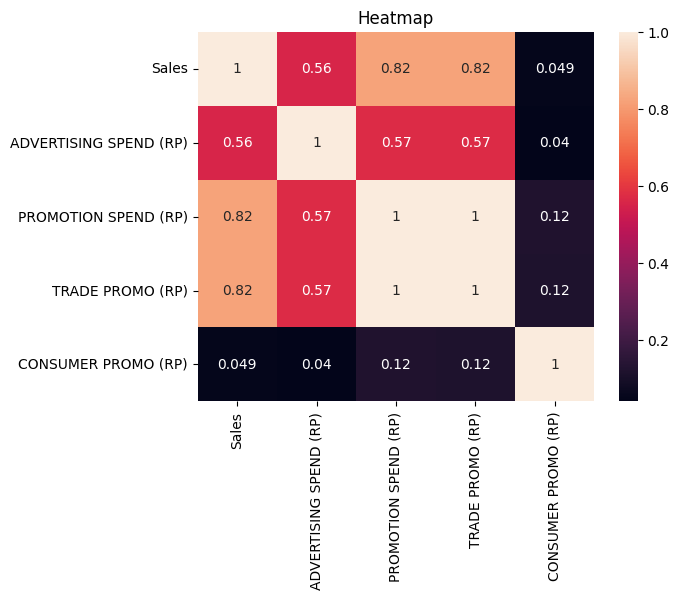

In [27]:
sns.heatmap(tango_df[['Sales']+exog_columns].corr(), annot=True)
plt.title("Heatmap")
plt.show()

# Modelling

In [91]:
from statsforecast import StatsForecast
from datetime import datetime
"""Data Preparation for StatsForecast modelling"""
TRAIN_CUTOFF = datetime(year=2022, month=12, day=1)

kp = 'TANGO WAFER'
omset_columns = ['Periode', 'KP', 'Sales']
aa_graph_columns = ['Periode', 'KP', 'Dimensi', 'Value']
exog_columns = ['ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)', 'CONSUMER PROMO (RP)']

# Data for statsforecast modelling
tango_df = get_data_by_kp(kp, omset_columns, aa_graph_columns)
tango_df = tango_df[['Periode', 'KP', 'Sales']+exog_columns]

# Split Data
train_df = tango_df[tango_df['Periode']<=TRAIN_CUTOFF].reset_index(drop=True)
test_df = tango_df[tango_df['Periode']>TRAIN_CUTOFF].reset_index(drop=True)

## Model Baseline

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Features and targets
features = ['CONSUMER PROMO (RP)', 'ADVERTISING SPEND (RP)', 'PROMOTION SPEND (RP)', 'TRADE PROMO (RP)']
target = 'Sales'

# Split into training features and targets
X_train, X_test, y_train, y_test = train_df[features], test_df[features], train_df[target], test_df[target]

# Standardized features
scaler = StandardScaler()
X_train_preprocessed = X_train.copy() 
X_train_preprocessed[features] = scaler.fit_transform(X_train)
X_test_preprocessed = X_test.copy() 
X_test_preprocessed[features] = scaler.transform(X_test)

# Prepare Model
lr = LinearRegression()

# Train
lr.fit(X_train_preprocessed, y_train)

# Evaluation
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_train, lr.predict(X_train)))))
print("R2: {}".format(r2_score(y_test, lr.predict(X_test))))

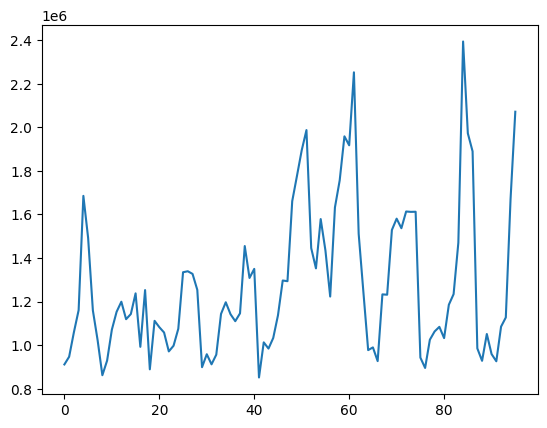

In [87]:
plt.plot(lr.predict(X_train_preprocessed))

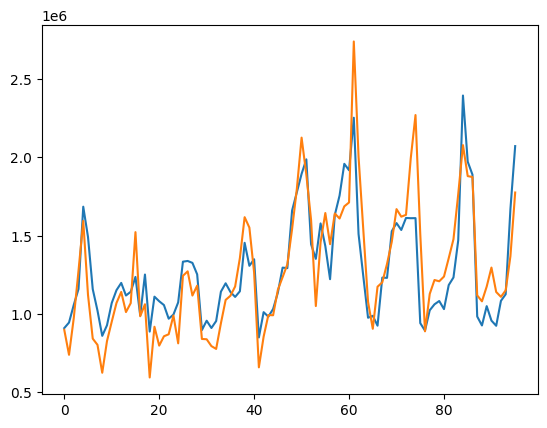

In [88]:
plt.plot(lr.predict(X_train_preprocessed))
plt.plot(y_train)

In [90]:
X_test_preprocessed

,CONSUMER PROMO (RP),ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP)
0,0.0,1.524177,4.187147,4.187147
1,0.0,4.938837,3.884898,3.884898
2,50200000.0,0.430066,0.294171,0.289500
3,23129250.0,-1.167106,-0.892819,-0.894972
4,30741000.0,-0.470404,-0.452796,-0.455657
5,3037500.0,-0.599985,-0.545383,-0.545666
6,0.0,-0.234935,-0.499070,-0.499070
7,0.0,-0.724882,-0.550537,-0.550537
8,0.0,-0.015937,-0.853307,-0.853307
9,0.0,-0.720166,0.291817,0.291817


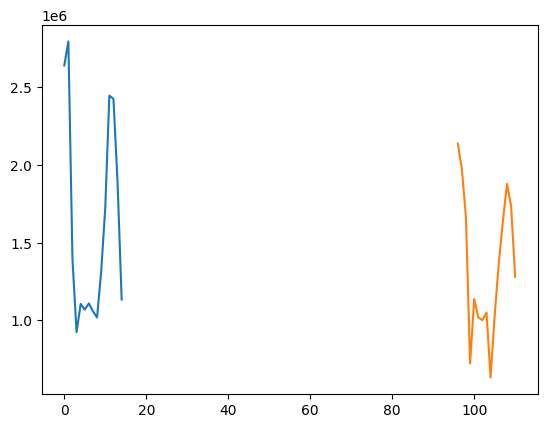

In [89]:
plt.plot(lr.predict(X_test_preprocessed))
plt.plot(y_test)

In [59]:
X_train_preprocessed.iloc[:, 0]

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
     ... 
91    0.0
92    0.0
93    0.0
94    0.0
95    0.0
Name: CONSUMER PROMO (RP), Length: 96, dtype: float64

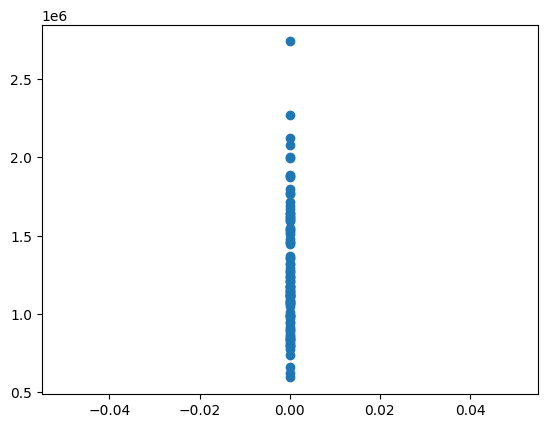

In [60]:
plt.scatter(X_train_preprocessed.iloc[:, 0], y_train)

,y,ADVERTISING SPEND (RP),PROMOTION SPEND (RP),TRADE PROMO (RP),CONSUMER PROMO (RP),TARPS CRYSTALIN
count,9.600000e+01,9.600000e+01,9.600000e+01,9.600000e+01,96.0,96.0
mean,4.605758e+05,1.006339e+09,1.691731e+09,1.691731e+09,0.0,0.0
std,3.543540e+05,9.260542e+08,1.192185e+09,1.192185e+09,0.0,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0
25%,1.543590e+04,2.797839e+08,6.877192e+08,6.877192e+08,0.0,0.0
50%,5.276538e+05,8.506523e+08,1.797151e+09,1.797151e+09,0.0,0.0
75%,7.662529e+05,1.575015e+09,2.511862e+09,2.511862e+09,0.0,0.0
max,1.108416e+06,4.369210e+09,4.434798e+09,4.434798e+09,0.0,0.0


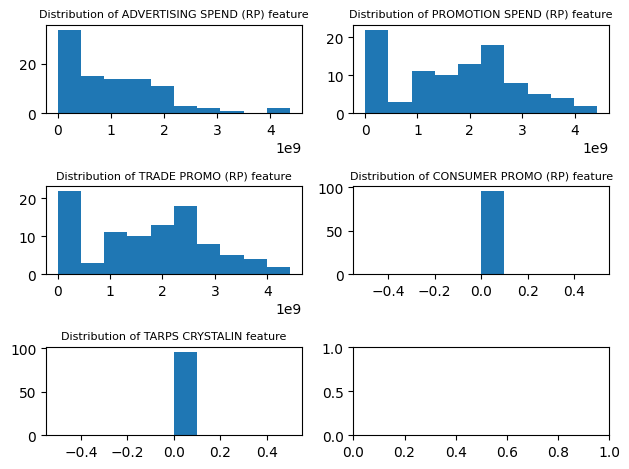

In [ ]:
from itertools import product
# Distribution of the data
display(train_df.select_dtypes('number').describe())

fig, ax = plt.subplots(3, 2)
for exog, (i, j) in zip(exog_columns, product(range(3), range(2))):
    ax[i, j].hist(train_df[exog])
    ax[i, j].set_title("Distribution of {} feature".format(exog), fontsize=8)
plt.tight_layout()

<Axes: >

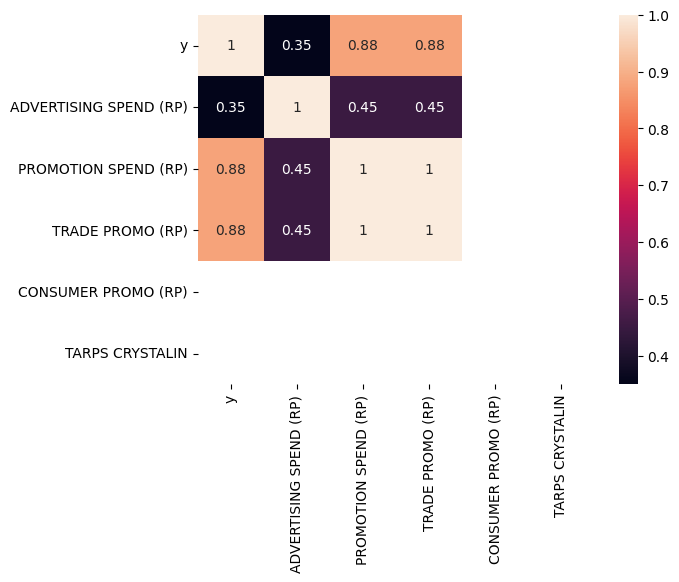

In [ ]:
import seaborn as sns
sns.heatmap(train_df.select_dtypes('number').corr(), annot=True)

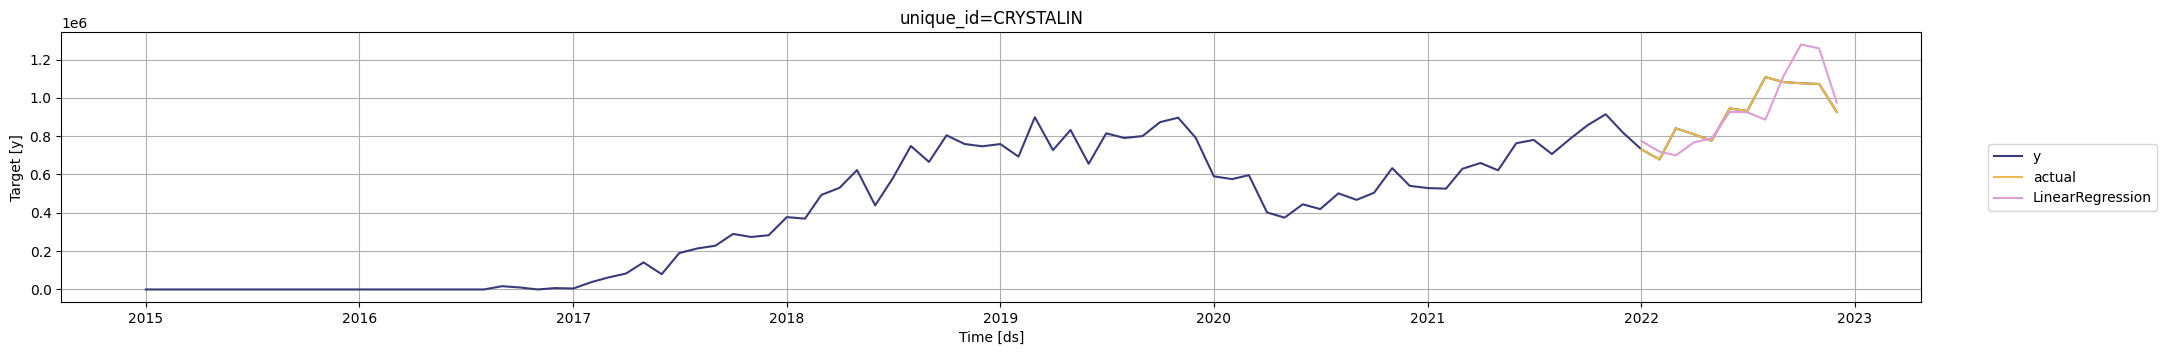

In [ ]:
from mlforecast import MLForecast
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from mlforecast.target_transforms import Differences,LocalStandardScaler
from mlforecast.lag_transforms import RollingMean, ExpandingMean
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.linear_model import LinearRegression

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(fit_intercept=False, n_jobs=-1))
    ])
]

ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],  # remove trend and seasonality
)

crossvalidation_df = ml.cross_validation(
    df=train_df, 
    h=1, 
    step_size=1,
    n_windows=12
)

# Plot Forecast
crossvalidation_df = crossvalidation_df.rename(columns = {'y' : 'actual'}) # rename `y`` to `actual`` values
StatsForecast.plot(train_df, crossvalidation_df.loc[:, crossvalidation_df.columns != 'cutoff'])

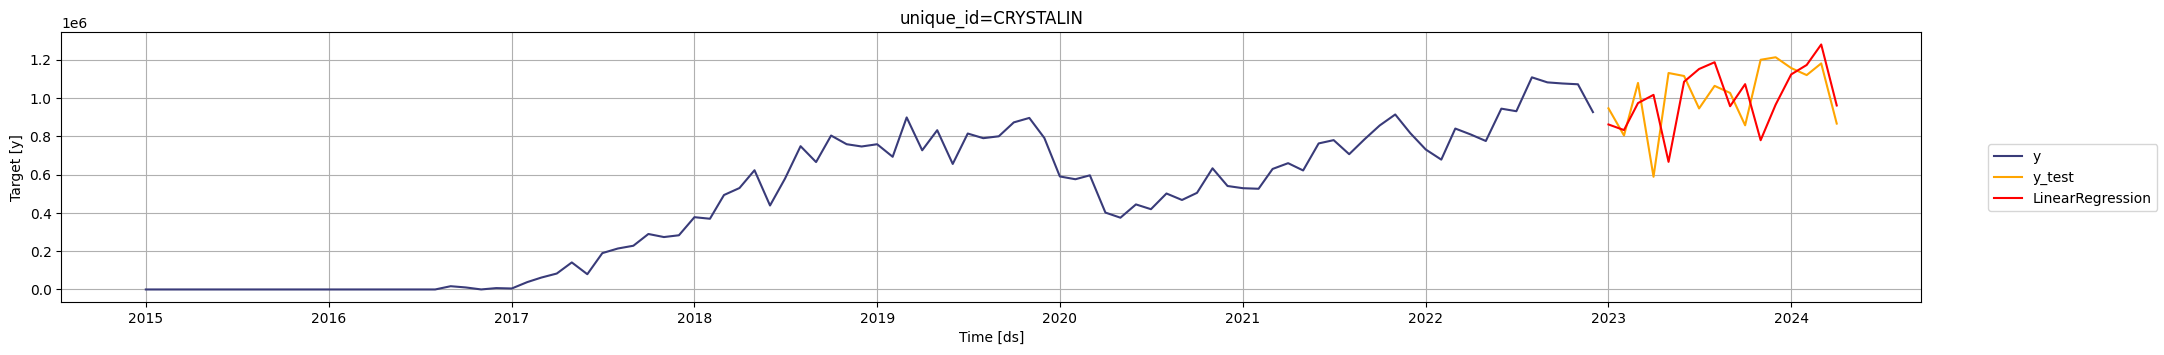

In [ ]:
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge

models = [
    Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression(fit_intercept=False, n_jobs=-1))
    ])
]
ml = MLForecast(
    freq = 'MS',
    models=models,
    lags=[i for i in range(1, 13)],
    target_transforms=[Differences([1, 12]), LocalStandardScaler()],
)

ml.fit(train_df, static_features=[])
forecast_df = pd.DataFrame()
X_df = test_df[['ds', 'unique_id'] + exog_columns]
for i, ds in enumerate(pd.date_range(start= TRAIN_CUTOFF + relativedelta(months=1), end=test_df.ds.max(), freq='1MS')):
    forecast_df = pd.concat([forecast_df, ml.predict(h=1, X_df=X_df)])
    new_data = pd.concat([train_df, test_df[test_df['ds'] <= ds].rename(columns={'y_test': 'y'})]).reset_index(drop=True)
    ml.update(new_data)

fig = StatsForecast.plot(
    df=train_df.sort_values(['ds']), 
    forecasts_df=test_df.merge(forecast_df, on=['ds', 'unique_id']).drop(columns=exog_columns)
)

# colot adjustment
y_test_color = "orange" 
model_color = "red" 

ax = fig.get_axes()[0]
ax.lines[1].set_color(y_test_color)
fig.legends[0].legend_handles[1].set_color(y_test_color)
ax.lines[2].set_color(model_color)
fig.legends[0].legend_handles[2].set_color(model_color)
fig 

Evaluate Model

In [ ]:
from revenue_forecasting.metrics import mae_percentage
# Function
def evaluate_crossvalidation(df: pd.DataFrame, target: str, models: list) -> None:
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

def evaluate_test(df: pd.DataFrame, target: str, models: list):
    eval_df = None
    for model in models:
        results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
        results.columns = ['unique_id', model]
        eval_df = results if eval_df is None else eval_df.merge(results, how='left', on='unique_id')
    return eval_df

eval_crossvalidation_df = evaluate_crossvalidation(crossvalidation_df, target='actual', models=['LinearRegression'])
eval_predict_df = evaluate_test(test_df.merge(forecast_df, on=['unique_id', 'ds']), target='y_test', models=['LinearRegression'])

eval_crossvalidation_df[[str(model) for model in ml.models.keys()]] = (1 - eval_crossvalidation_df[[str(model) for model in ml.models.keys()]])* 100
eval_predict_df[[str(model) for model in ml.models.keys()]] = (1 - eval_predict_df[[str(model) for model in ml.models.keys()]]) * 100

print('crossvalidation accuracy')
display(eval_crossvalidation_df)
print('test accuracy')
display(eval_predict_df)

2024-07-19 14:03:19.472 | INFO     | revenue_forecasting.config:<module>:11 - PROJ_ROOT path is: D:\Documents\GitHub\revenue-forecasting


crossvalidation accuracy


C:\Users\923006079\AppData\Local\Temp\ipykernel_6648\4096236871.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], x[model])).reset_index()
C:\Users\923006079\AppData\Local\Temp\ipykernel_6648\4096236871.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = df.groupby('unique_id').apply(lambda x: mae_percentage(x[target], 

,unique_id,LinearRegression
0,CRYSTALIN,90.945168


test accuracy


,unique_id,LinearRegression
0,CRYSTALIN,83.426228


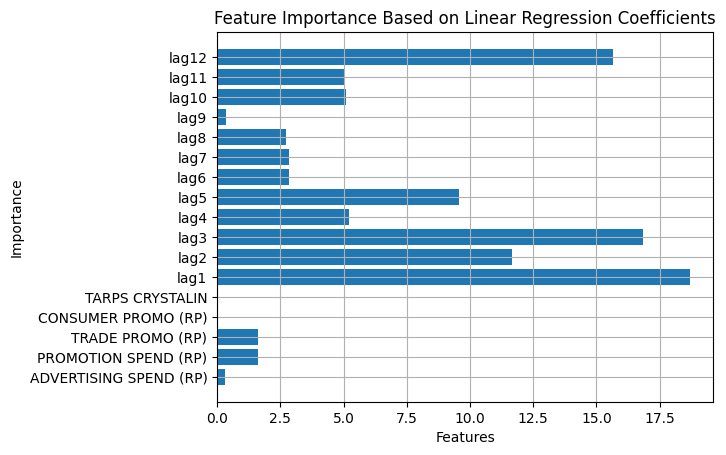

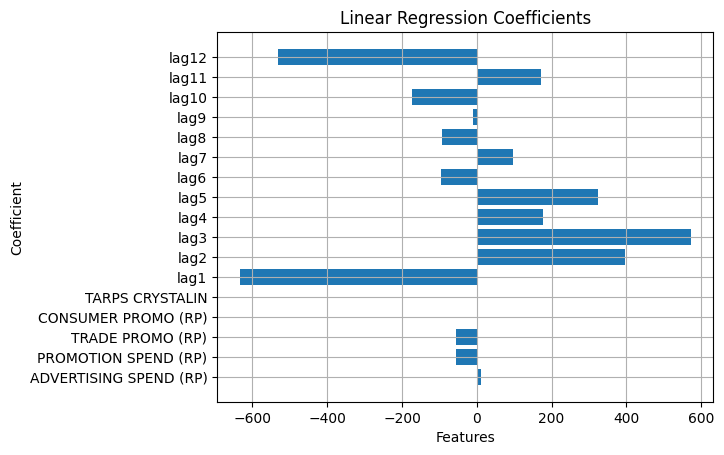

,feature,importance
5,lag1,18.68
7,lag3,16.85
16,lag12,15.64
6,lag2,11.64
9,lag5,9.56
8,lag4,5.22
14,lag10,5.11
15,lag11,5.07
11,lag7,2.83
10,lag6,2.82


In [ ]:
import matplotlib.pyplot as plt
def plot_lr_feature_importance(features, coefficients):
    coefficients = abs(coefficients)
    plt.barh(features, coefficients/ sum(coefficients) * 100)
    plt.grid()
    plt.title("Feature Importance Based on Linear Regression Coefficients")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()

def plot_lr_coefficient(features, coefficients):
    plt.barh(features, coefficients/ sum(coefficients) * 100)
    plt.grid()
    plt.title("Linear Regression Coefficients")
    plt.xlabel("Features")
    plt.ylabel("Coefficient")
    plt.show()

def create_feature_importance_df(features, coefficients):
    coefficients = np.abs(coefficients)
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    return pd.DataFrame(
        {
            'feature': features,
            'importance': coefficients / sum(coefficients) * 100
        }
    ).sort_values(by='importance', ascending=False)

plot_lr_feature_importance(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

plot_lr_coefficient(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)

create_feature_importance_df(
    ml.models_['LinearRegression'].feature_names_in_,
    ml.models_['LinearRegression']['regressor'].coef_ 
)